In [1]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import matplotlib as plt
import geoplot.crs as gcrs
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
national_fips_codes = pd.read_csv('covid_scraper/data/state_fips_codes_2017.csv', dtype=str)
national_fips_codes = national_fips_codes[national_fips_codes['State (FIPS)'] != '00']
national_fips_codes = national_fips_codes.rename(columns={'State (FIPS)': 'st_fips', 'Name': 'st_name'}).drop(columns=['Region', 'Division'])
national_fips_codes

st_fips               st_name
2       09           Connecticut
3       23                 Maine
4       25         Massachusetts
5       33         New Hampshire
6       44          Rhode Island
7       50               Vermont
9       34            New Jersey
10      36              New York
11      42          Pennsylvania
14      17              Illinois
15      18               Indiana
16      26              Michigan
17      39                  Ohio
18      55             Wisconsin
20      19                  Iowa
21      20                Kansas
22      27             Minnesota
23      29              Missouri
24      31              Nebraska
25      38          North Dakota
26      46          South Dakota
29      10              Delaware
30      11  District of Columbia
31      12               Florida
32      13               Georgia
33      24              Maryland
34      37        North Carolina
35      45        South Carolina
36      51              Virginia
37      54         West Virginia
39      01               Alabama
40      21              Kentucky
41      28           Mississippi
42      47             Tennessee
44      05              Arkansas
45      22             Louisiana
46      40              Oklahoma
47      48                 Texas
50      04               Arizona
51      08              Colorado
52      16                 Idaho
53      30               Montana
54      32                Nevada
55      35            New Mexico
56      49                  Utah
57      56               Wyoming
59      02                Alaska
60      06            California
61      15                Hawaii
62      41                Oregon
63      53            Washington

In [3]:
hotspots_recent = pd.read_csv('covid_scraper/exports/midwest_emerging_counties.csv', dtype={'state_fips': 'object', 'fips': 'object'})
hotspots_recent.head()

date state_fips   fips state   county  cases  deaths  pop_2019  \
0  2020-04-28         19  19179  Iowa  Wapello     10       0   34969.0   
1  2020-04-09         19  19179  Iowa  Wapello      2       0   34969.0   
2  2020-04-11         19  19179  Iowa  Wapello      4       0   34969.0   
3  2020-04-13         19  19179  Iowa  Wapello      6       0   34969.0   
4  2020-04-14         19  19179  Iowa  Wapello      7       0   34969.0   

   cases_p_100k  deaths_p_100k  latitude  longitude  cases_daily_pct_change  \
0          28.6            0.0   41.0313   -92.4095                0.000000   
1           5.7            0.0   41.0313   -92.4095                0.000000   
2          11.4            0.0   41.0313   -92.4095                0.333333   
3          17.2            0.0   41.0313   -92.4095                0.500000   
4          20.0            0.0   41.0313   -92.4095                0.166667   

   deaths_daily_pct_change  cases_weekly_pct_change  deaths_weekly_pct_change  
0                      NaN                 0.462488                       NaN  
1                      NaN                 0.462488                       NaN  
2                      NaN                 0.462488                       NaN  
3                      NaN                 0.462488                       NaN  
4                      NaN                 0.462488                       NaN

In [4]:
hotspot_states = hotspots_recent[['state_fips', 'state']].drop_duplicates()
hotspot_states

state_fips         state
0            19          Iowa
44           31      Nebraska
78           27     Minnesota
297          17      Illinois
400          18       Indiana
501          46  South Dakota
839          26      Michigan
1678         55     Wisconsin
3938         38  North Dakota

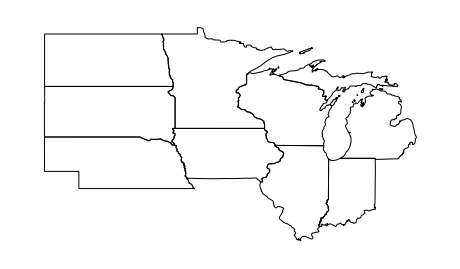

In [5]:
# contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
# gplt.polyplot(contiguous_usa)
state_shorelines = gpd.read_file("/Users/Coreymj/Documents/GIS/natural_earth/ne_10m_admin_1_states_provinces_lakes/ne_10m_admin_1_states_provinces_lakes.shp")
state_shorelines = state_shorelines[(state_shorelines['iso_a2'] == 'US') & (state_shorelines['name'].isin(hotspot_states['state']))]
# state_shorelines.crs
# state_shorelines = state_shorelines.to_crs("EPSG:26915")
# state_shorelines.crs
gplt.polyplot(state_shorelines)

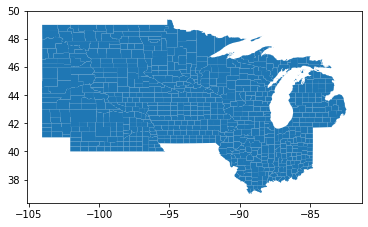

In [18]:
# counties = gpd.read_file("/Users/Coreymj/Documents/GIS/usa/tl_2019_us_county/tl_2019_us_county.shp")
counties = gpd.read_file("/Users/Coreymj/Documents/GIS/usa/USA County Shorelines/usa_county_shorelines_update.shp", dtype={'FIPS': str})
counties['FIPS'] = counties['FIPS'].astype(str)
counties['FIPS'] = counties['FIPS'].str.pad(width=5, side='left', fillchar='0')
# counties.dtypes
# counties['full_fips'] = counties.STATEFP + counties.COUNTYFP
counties['st_fips'] = counties['FIPS'].str[0:2]
counties['cty_fips'] = counties['FIPS'].str[2:]
counties.dtypes
counties = counties.rename(columns={'FIPS': 'full_fips', 'NAME': 'cty_name'})
counties = counties.merge(national_fips_codes,
                         how="left",
                         on="st_fips")
# counties
# counties[~counties['st_name'].isnull()].to_file("covid_scraper/data/shp/usa_county_shorelines/usa_county_shorelines.shp")

hotspot_state_counties = counties[counties['st_fips'].isin(hotspot_states.state_fips)]
hotspot_state_counties
hotspot_state_counties.plot()


In [11]:
state_srids = {
    'Minnesota': 26992, # 26915,
    'Iowa': 26915,
    'Wisconsin': 3071, # 26916,
    'Illinois': 26916,
    'Michigan': 26916,
    'Indiana': 26916,
    'North Dakota': 26914,
    'South Dakota': 26914,
    'Nebraska': 26914,
}

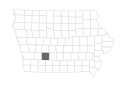

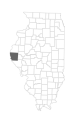

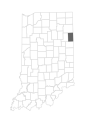

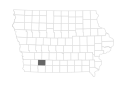

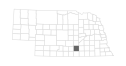

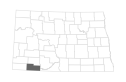

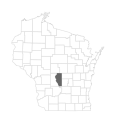

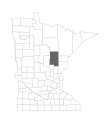

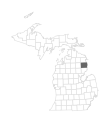

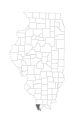

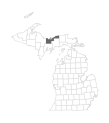

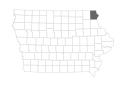

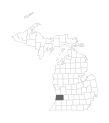

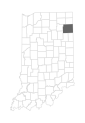

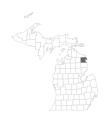

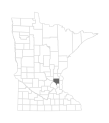

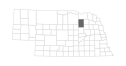

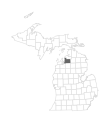

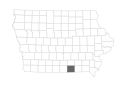

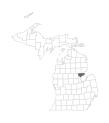

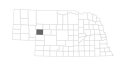

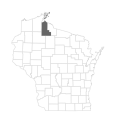

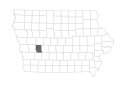

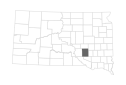

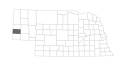

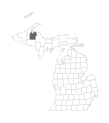

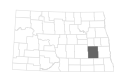

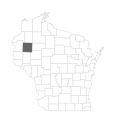

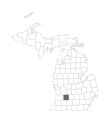

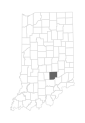

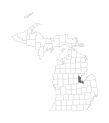

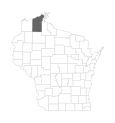

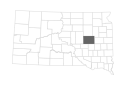

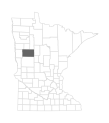

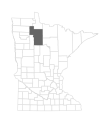

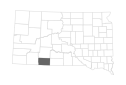

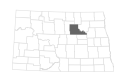

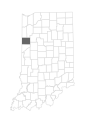

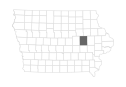

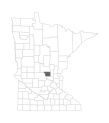

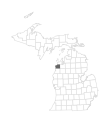

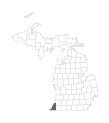

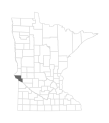

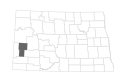

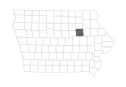

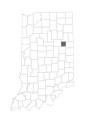

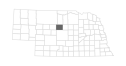

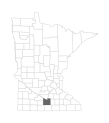

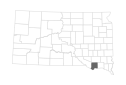

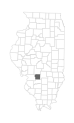

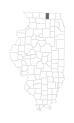

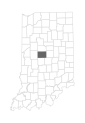

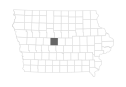

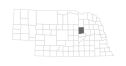

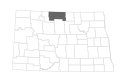

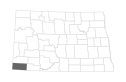

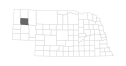

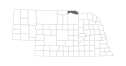

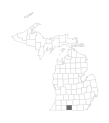

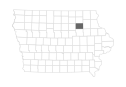

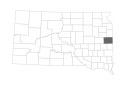

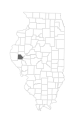

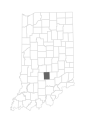

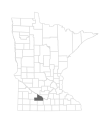

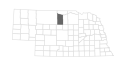

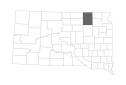

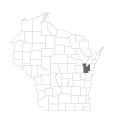

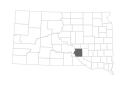

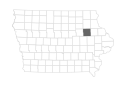

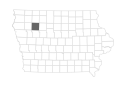

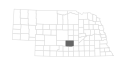

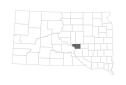

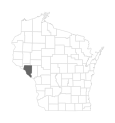

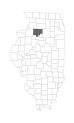

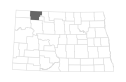

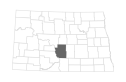

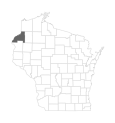

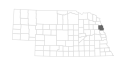

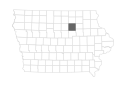

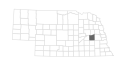

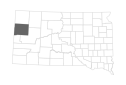

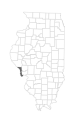

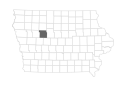

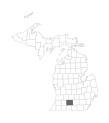

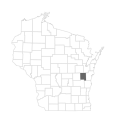

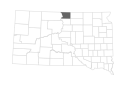

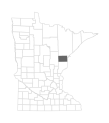

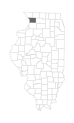

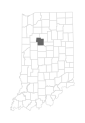

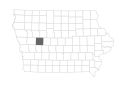

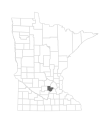

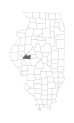

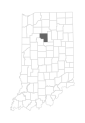

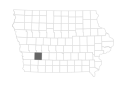

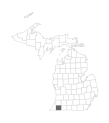

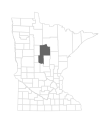

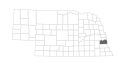

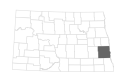

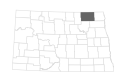

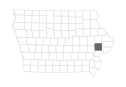

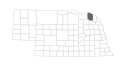

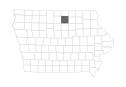

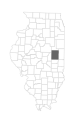

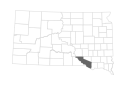

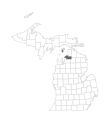

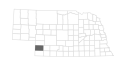

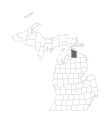

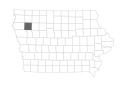

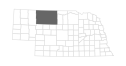

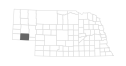

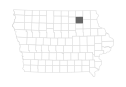

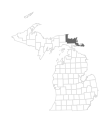

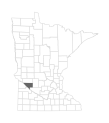

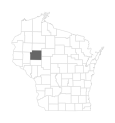

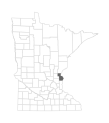

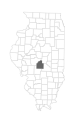

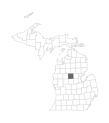

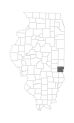

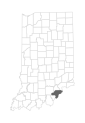

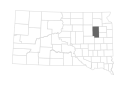

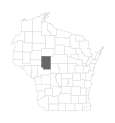

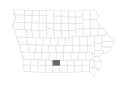

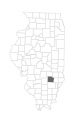

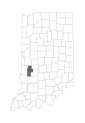

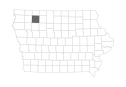

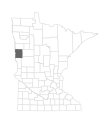

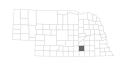

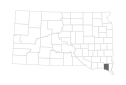

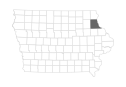

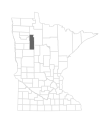

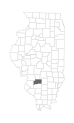

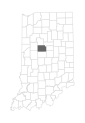

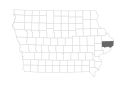

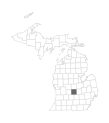

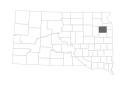

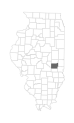

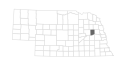

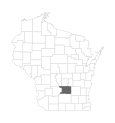

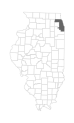

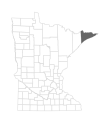

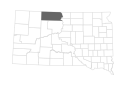

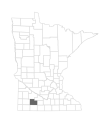

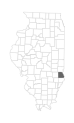

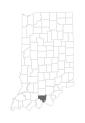

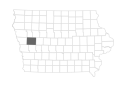

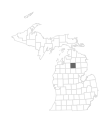

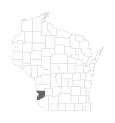

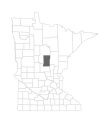

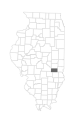

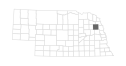

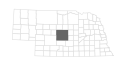

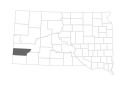

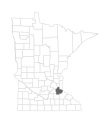

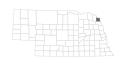

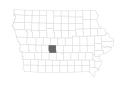

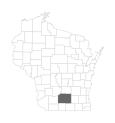

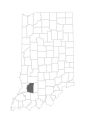

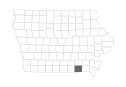

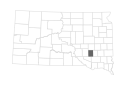

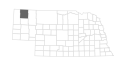

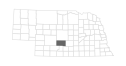

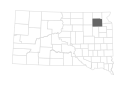

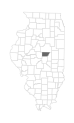

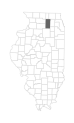

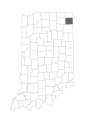

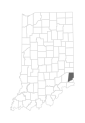

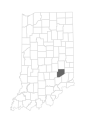

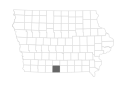

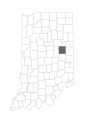

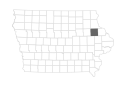

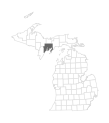

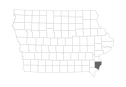

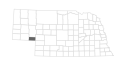

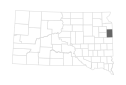

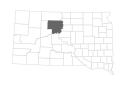

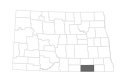

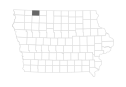

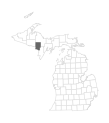

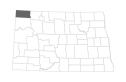

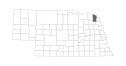

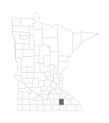

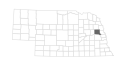

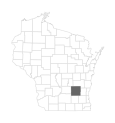

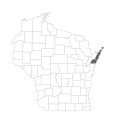

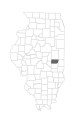

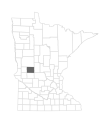

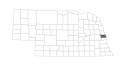

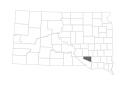

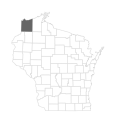

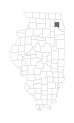

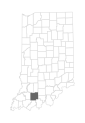

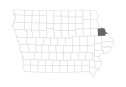

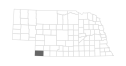

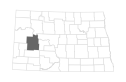

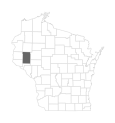

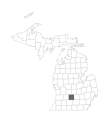

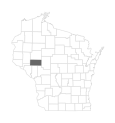

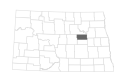

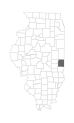

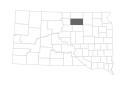

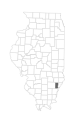

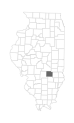

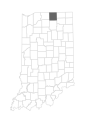

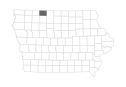

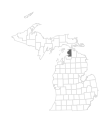

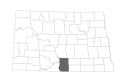

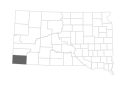

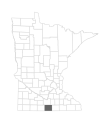

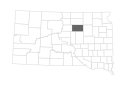

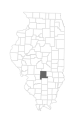

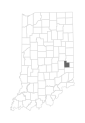

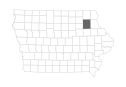

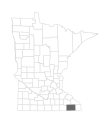

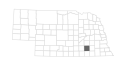

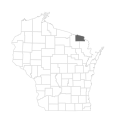

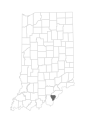

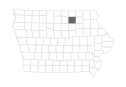

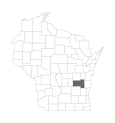

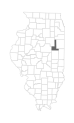

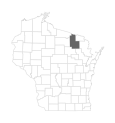

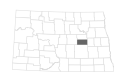

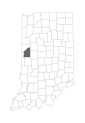

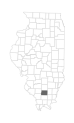

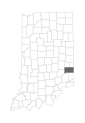

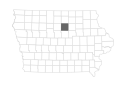

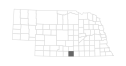

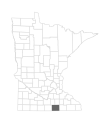

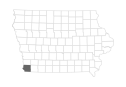

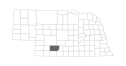

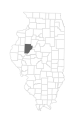

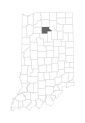

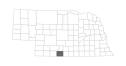

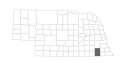

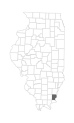

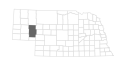

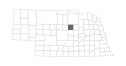

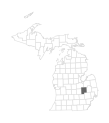

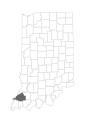

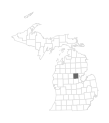

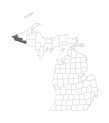

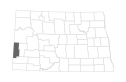

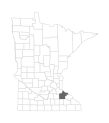

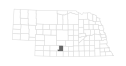

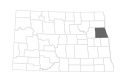

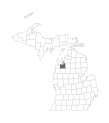

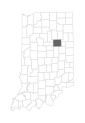

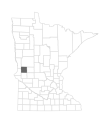

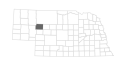

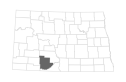

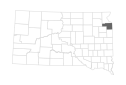

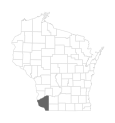

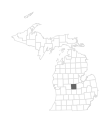

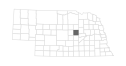

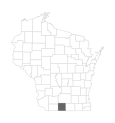

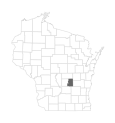

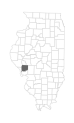

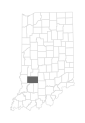

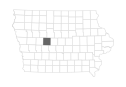

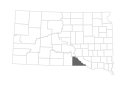

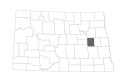

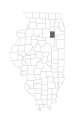

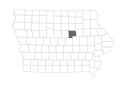

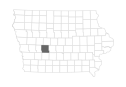

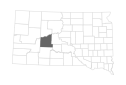

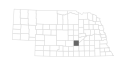

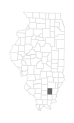

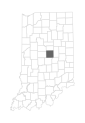

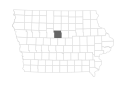

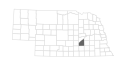

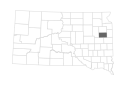

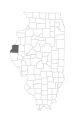

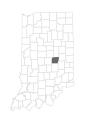

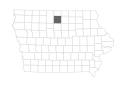

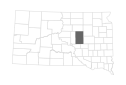

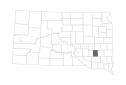

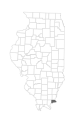

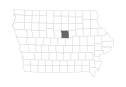

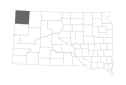

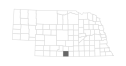

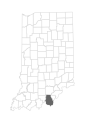

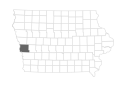

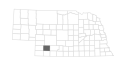

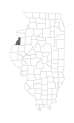

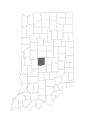

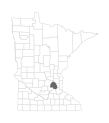

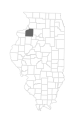

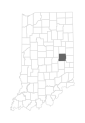

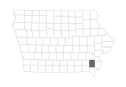

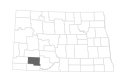

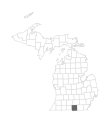

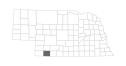

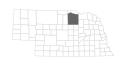

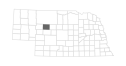

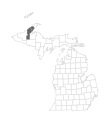

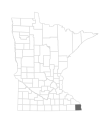

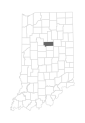

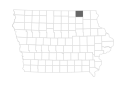

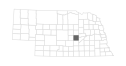

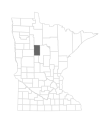

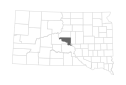

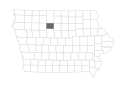

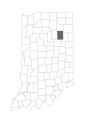

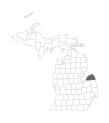

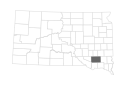

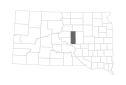

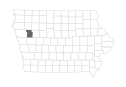

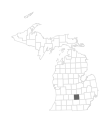

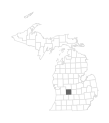

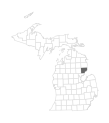

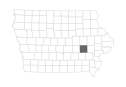

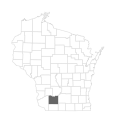

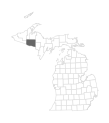

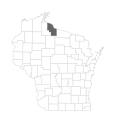

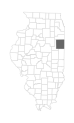

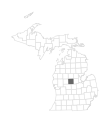

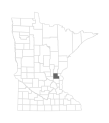

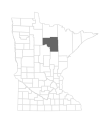

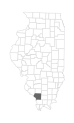

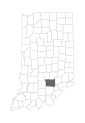

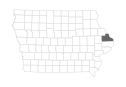

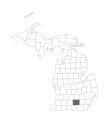

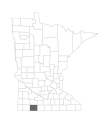

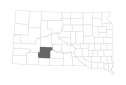

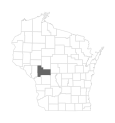

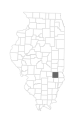

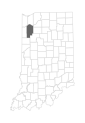

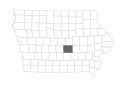

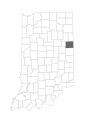

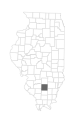

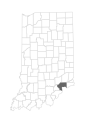

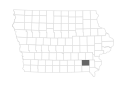

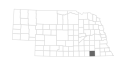

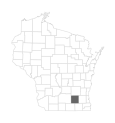

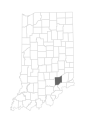

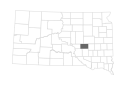

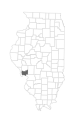

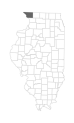

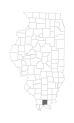

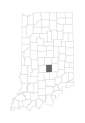

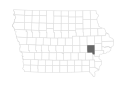

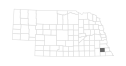

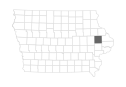

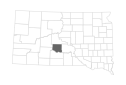

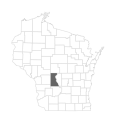

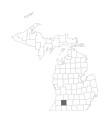

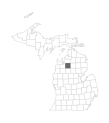

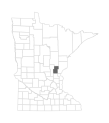

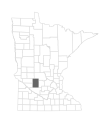

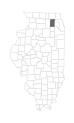

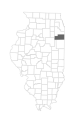

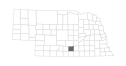

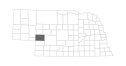

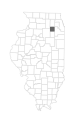

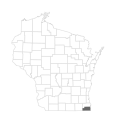

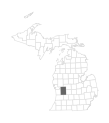

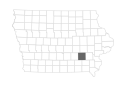

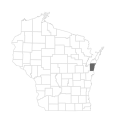

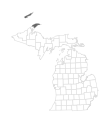

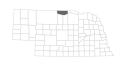

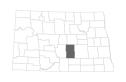

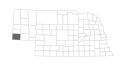

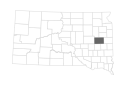

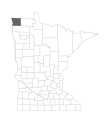

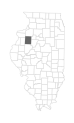

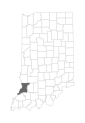

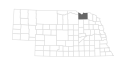

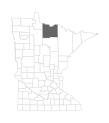

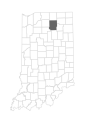

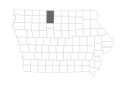

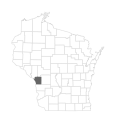

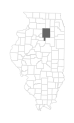

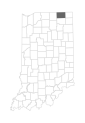

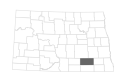

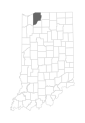

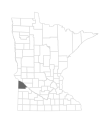

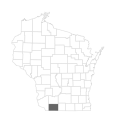

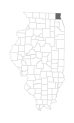

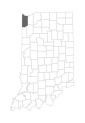

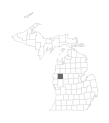

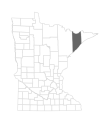

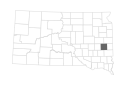

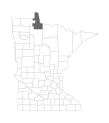

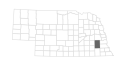

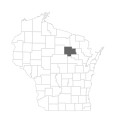

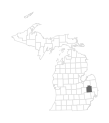

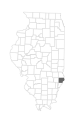

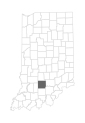

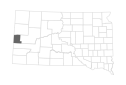

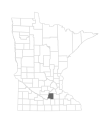

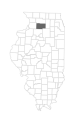

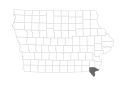

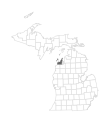

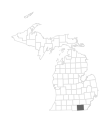

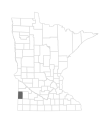

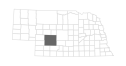

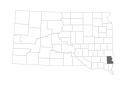

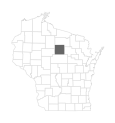

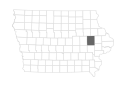

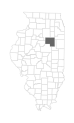

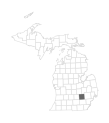

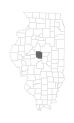

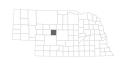

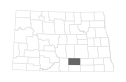

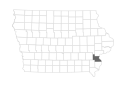

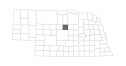

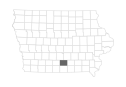

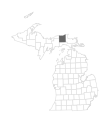

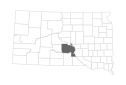

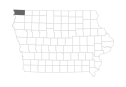

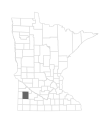

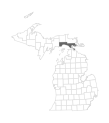

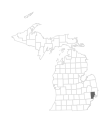

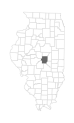

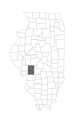

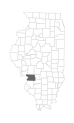

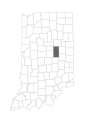

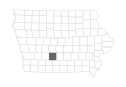

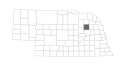

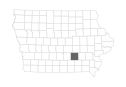

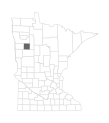

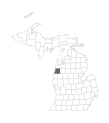

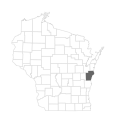

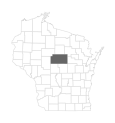

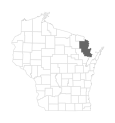

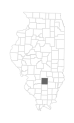

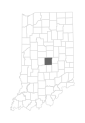

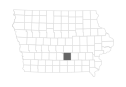

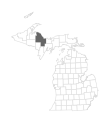

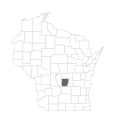

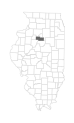

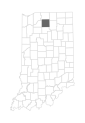

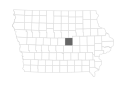

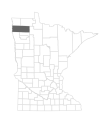

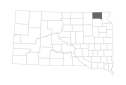

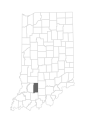

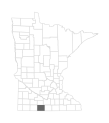

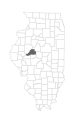

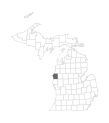

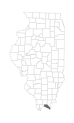

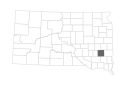

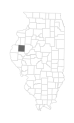

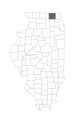

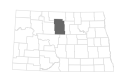

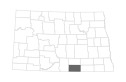

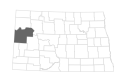

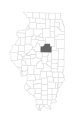

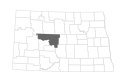

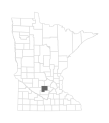

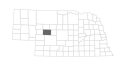

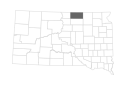

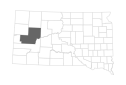

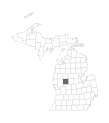

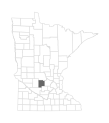

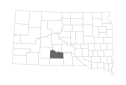

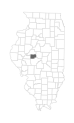

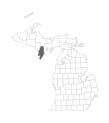

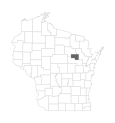

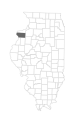

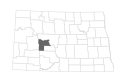

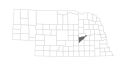

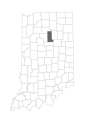

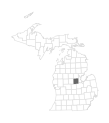

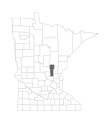

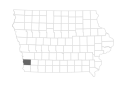

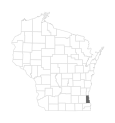

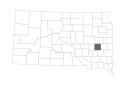

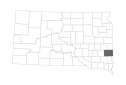

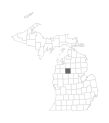

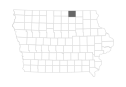

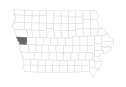

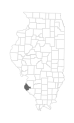

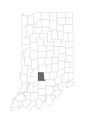

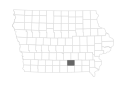

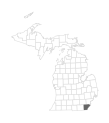

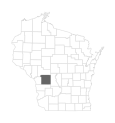

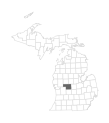

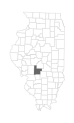

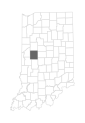

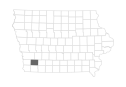

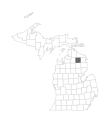

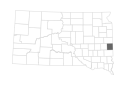

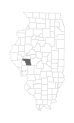

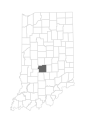

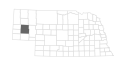

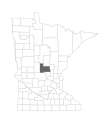

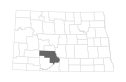

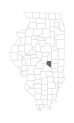

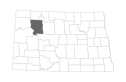

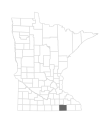

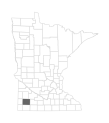

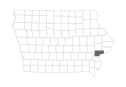

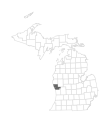

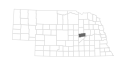

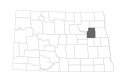

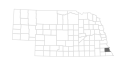

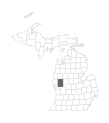

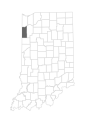

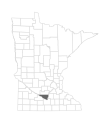

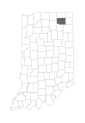

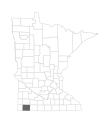

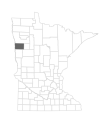

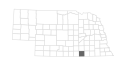

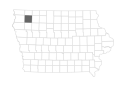

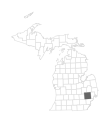

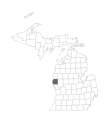

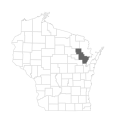

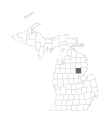

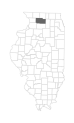

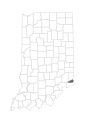

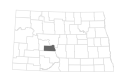

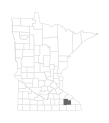

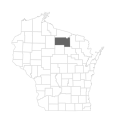

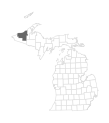

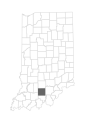

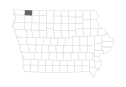

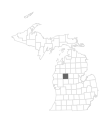

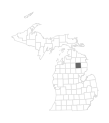

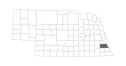

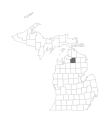

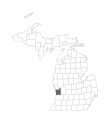

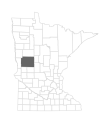

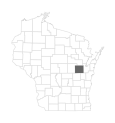

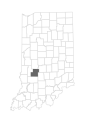

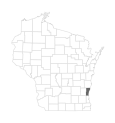

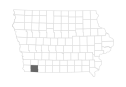

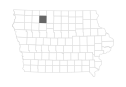

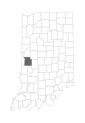

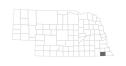

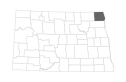

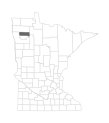

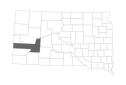

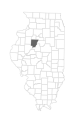

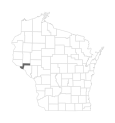

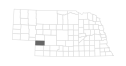

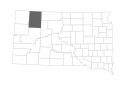

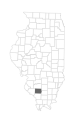

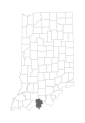

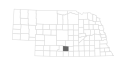

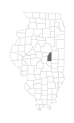

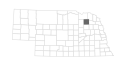

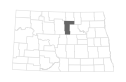

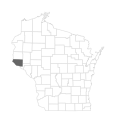

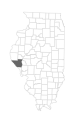

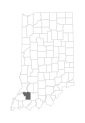

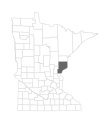

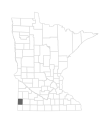

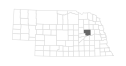

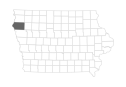

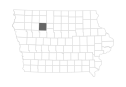

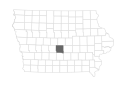

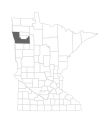

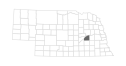

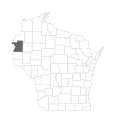

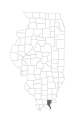

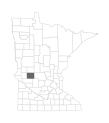

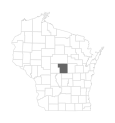

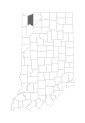

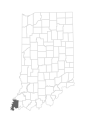

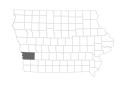

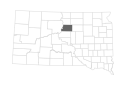

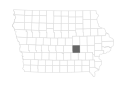

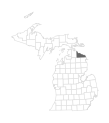

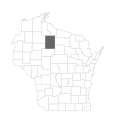

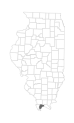

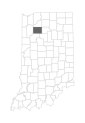

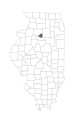

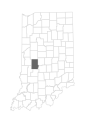

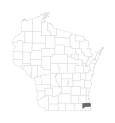

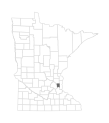

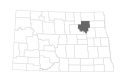

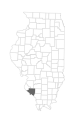

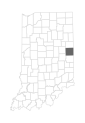

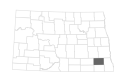

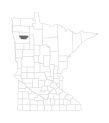

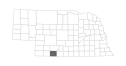

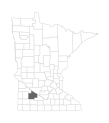

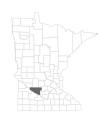

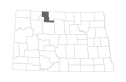

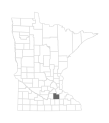

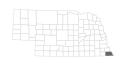

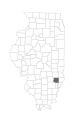

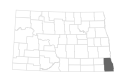

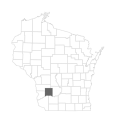

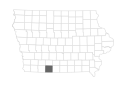

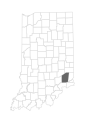

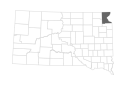

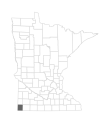

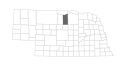

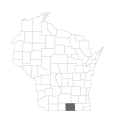

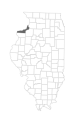

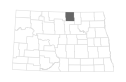

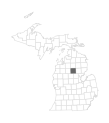

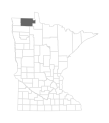

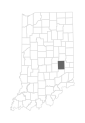

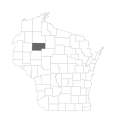

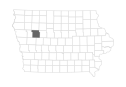

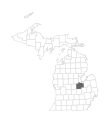

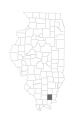

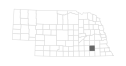

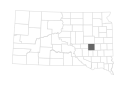

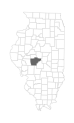

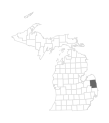

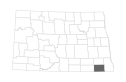

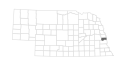

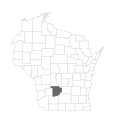

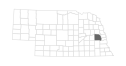

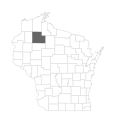

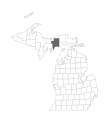

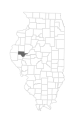

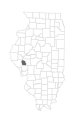

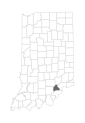

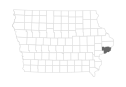

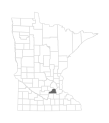

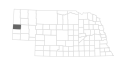

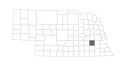

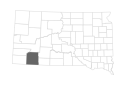

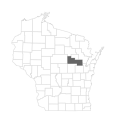

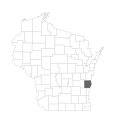

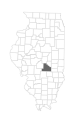

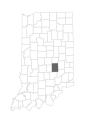

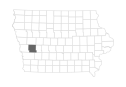

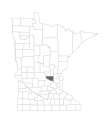

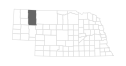

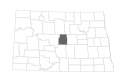

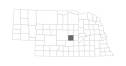

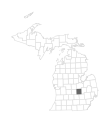

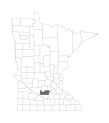

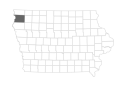

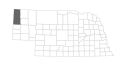

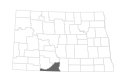

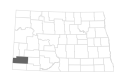

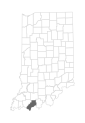

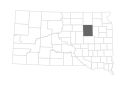

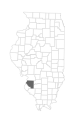

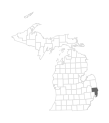

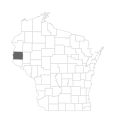

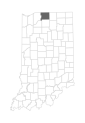

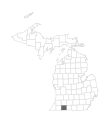

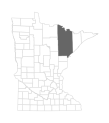

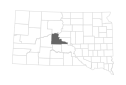

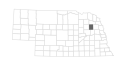

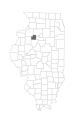

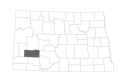

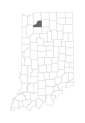

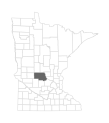

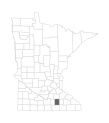

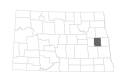

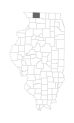

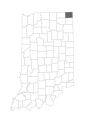

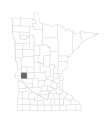

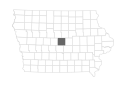

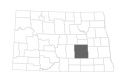

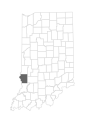

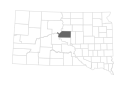

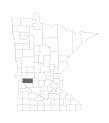

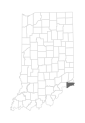

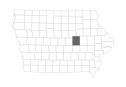

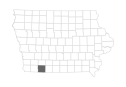

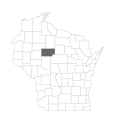

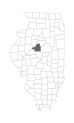

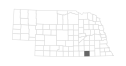

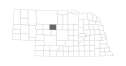

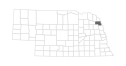

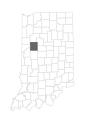

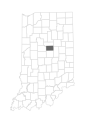

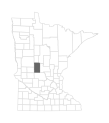

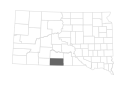

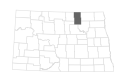

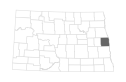

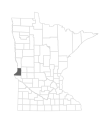

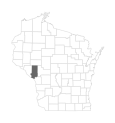

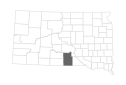

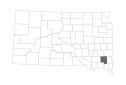

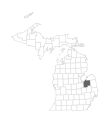

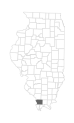

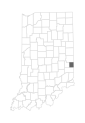

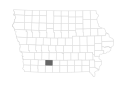

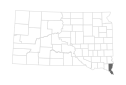

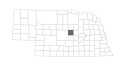

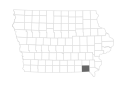

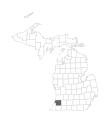

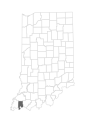

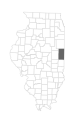

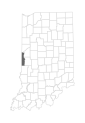

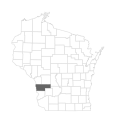

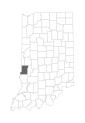

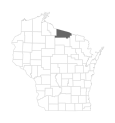

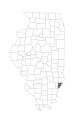

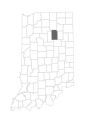

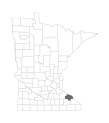

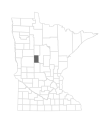

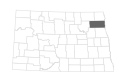

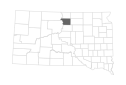

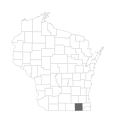

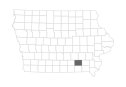

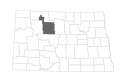

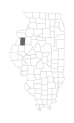

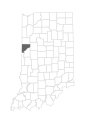

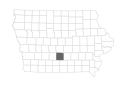

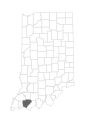

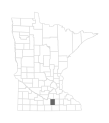

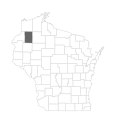

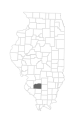

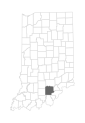

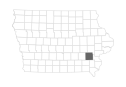

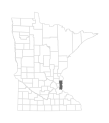

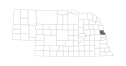

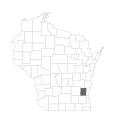

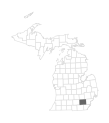

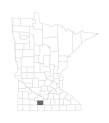

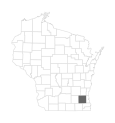

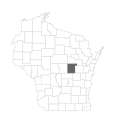

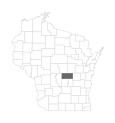

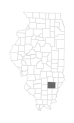

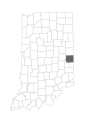

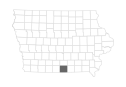

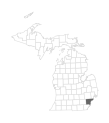

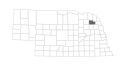

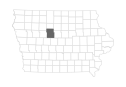

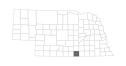

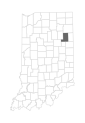

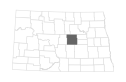

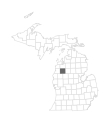

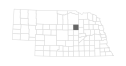

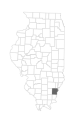

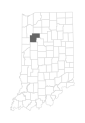

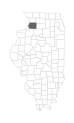

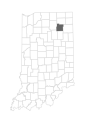

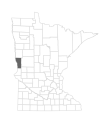

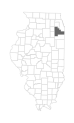

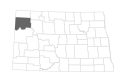

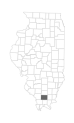

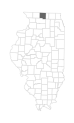

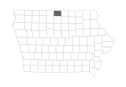

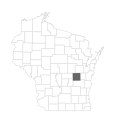

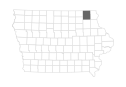

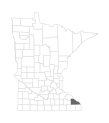

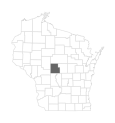

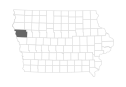

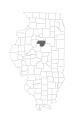

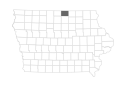

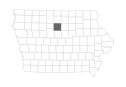

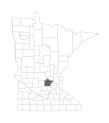

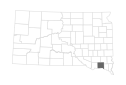

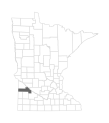

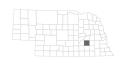

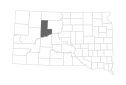

In [12]:
# for c in hotspots_recent[['state_fips', 'fips', 'state', 'county']].drop_duplicates().iterrows():
for c in hotspot_state_counties.iterrows():  # All counties in those states, might as well
    proj = 'EPSG:{}'.format(state_srids[c[1]['st_name']])
    all_county_shp = hotspot_state_counties[hotspot_state_counties['st_fips'] == c[1]['st_fips']].to_crs(proj)
    county_shp = all_county_shp[all_county_shp['full_fips'] == c[1]['full_fips']]  
#     county_shp = all_county_shp[all_county_shp['FIPS'] == c[1]['fips']]                                               
#     state_shp = state_shorelines[state_shorelines['name'] == c[1]['state']].to_crs(proj)
    
#     base = state_shp.plot(color='white', edgecolor='black')
    base = all_county_shp.plot(color='white', edgecolor='#DDDDDD', linewidth=0.5, figsize=(2, 2))
    outmap = county_shp.plot(ax=base, color='#666666')
    outmap.axis('off')
    outmap.figure.savefig(
        'covid_scraper/exports/locator_maps/county_{}.png'.format(c[1]['full_fips']),
        bbox_inches='tight',
        pad_inches=0,
        transparent=True
    )
    